# Détection de Défauts de Casting avec CNN
## Projet :  IA et Industrie 4.0

---

### Informations du Projet
- **Titre** : Étude des Robots et IA dans les Usines
- **Module** : Les compétences en IA
- **Objectif** : Classification binaire de pièces de fonderie (défaut / ok)
- **Dataset** : Casting Product Image Data for Quality Inspection (Kaggle)
- **Technologie** : CNN (Convolutional Neural Network) avec TensorFlow/Keras

---

### Structure du Dataset
casting_data/  
├── train/  
│   ├── def_front/  
│   └── ok_front/  
└── test/  
    ├── def_front/  
    └── ok_front/



**Total** : 6,634 images d'entraînement | 715 images de test

---

### Objectif du Modèle
Développer un système de contrôle qualité automatisé capable de : 
- Détecter automatiquement les défauts de surface sur les pièces de fonderie
- Classifier les pièces en deux catégories : **OK** ou **DÉFAUT**
- Atteindre une précision >90% pour une utilisation industrielle

---

In [1]:
# Importation de TensorFlow, la bibliothèque principale pour le deep learning
import tensorflow as tf

# Importation des couches (layers) et modèles pour construire un CNN
from tensorflow.keras import layers, models

# Outils Keras pour le chargement et le prétraitement des images
from tensorflow.keras.preprocessing import image

# Bibliothèque pour l'affichage de graphiques (courbes, images, résultats)
import matplotlib.pyplot as plt

# Bibliothèque pour le calcul numérique (tableaux, opérations mathématiques)
import numpy as np

# Bibliothèque pour interagir avec le système de fichiers (dossiers, chemins)
import os

---

## Configuration et Chargement des Données

### Chemin du Dataset
Le dataset est organisé en deux dossiers principaux :
- **`train/`** : Pour l'entraînement du modèle
- **`test/`** : Pour l'évaluation finale des performances

Chaque dossier contient deux sous-dossiers correspondant aux classes :
- **`def_front`** : Images avec défauts
- **`ok_front`** : Images sans défaut (pièces conformes)

---

In [2]:
chemin_base = "E:\\ISMAGI\\CI2 sem1\\IA\\Projet\\datasets\\quality\\casting_data"

---

### Chargement des Datasets avec `image_dataset_from_directory`

Cette fonction Keras permet de : 
- Charger automatiquement les images depuis des dossiers organisés par classe
- Assigner automatiquement les labels (0 pour `def_front`, 1 pour `ok_front`)
- Redimensionner toutes les images à une taille uniforme (250×250 pixels)
- Organiser les données en **batches** pour optimiser l'entraînement

#### Paramètres Importants :
- **`image_size=(250, 250)`** : Toutes les images sont redimensionnées à 250×250 pixels
- **`batch_size=16`** : Le modèle traitera 16 images à la fois
- **Labels automatiques** : Keras assigne les labels par ordre alphabétique
  - Label **0** → `def_front` (défaut)
  - Label **1** → `ok_front` (pièce conforme)

---

In [3]:
# Création d'un dataset d'images à partir d'un dossier contenant les images
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    # Chemin vers le dossier contenant les images d'entraînement
    os.path.join(chemin_base, "train"),

    # Redimensionnement de toutes les images à 250x250 pixels
    image_size=(250, 250),

    # Nombre d'images par batch lors de l'entraînement
    batch_size=16,
)


Found 6634 files belonging to 2 classes.


In [4]:
# Création du dataset d'images pour les tests à partir d'un dossier
dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    # Chemin vers le dossier contenant les images de test
    os.path.join(chemin_base, "test"),

    # Redimensionnement de toutes les images à 250x250 pixels
    image_size=(250, 250),

    # Nombre d'images traitées simultanément (taille du batch)
    batch_size=16,
)


Found 715 files belonging to 2 classes.


---

## Prétraitement des Données :  Normalisation

### Pourquoi Normaliser les Images ? 

Les pixels d'une image sont initialement encodés avec des valeurs entre **0 et 255** : 
- 0 = noir complet
- 255 = blanc complet

**Problème** : Ces grandes valeurs ralentissent et déstabilisent l'entraînement du réseau.

**Solution** : Normaliser les pixels dans l'intervalle **[0, 1]** en divisant par 255.

### Avantages de la Normalisation : 
1. **Convergence plus rapide** : Le modèle apprend plus vite
2. **Stabilité numérique** : Évite les gradients qui explosent
3. **Performances améliorées** : Meilleure généralisation

### Implémentation avec `Rescaling`
Keras fournit une couche dédiée qui divise automatiquement chaque pixel par 255.

---

In [5]:
normalisation = layers.Rescaling(1./255)

# Application de la normalisation sur le dataset d'entraînement
# map() applique la fonction à chaque batch (x, y) :
#   x → images du batch (normalisées)
#   y → labels du batch (inchangés)
dataset_train = dataset_train.map(lambda x, y: (normalisation(x), y))

# Application de la normalisation sur le dataset de test
# Assure que les images de test sont sur la même échelle que les images d'entraînement
dataset_test = dataset_test.map(lambda x, y: (normalisation(x), y))


---

## Construction de l'Architecture CNN

### Qu'est-ce qu'un CNN (Convolutional Neural Network) ?

Un **CNN** est un type de réseau de neurones spécialisé pour le traitement d'images.  Il utilise : 

1. **Couches de Convolution** : Détectent des motifs visuels (contours, textures, formes)
2. **Couches de Pooling** :  Réduisent la taille des données tout en conservant l'information importante
3. **Couches Dense** : Prennent la décision finale de classification


### Détails Techniques : 
- **Filtres croissants** : 32 → 64 → 128 → 256 (capture progressive de détails)
- **Fonction d'activation ReLU** : Introduit la non-linéarité
- **MaxPooling** : Réduit la dimension spatiale de moitié à chaque étape
- **Dropout 50%** : Désactive aléatoirement la moitié des neurones pour éviter le surapprentissage
- **Sigmoid en sortie** : Produit une probabilité entre 0 et 1

---


In [8]:
# Création d'un modèle CNN séquentiel
model = models.Sequential([

    # Couche d'entrée explicite
    layers.Input(shape=(250, 250, 3)),
    
    # Bloc 1 : Convolution + Pooling
    # - 32 filtres de taille 3x3
    # - input_shape correspond à la taille des images (250x250 pixels, 3 canaux RGB)
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Bloc 2 : Convolution + Pooling
    # - 64 filtres de taille 3x3
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Bloc 3 : Convolution + Pooling
    # - 128 filtres pour extraire des caractéristiques plus complexes
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Bloc 4 : Convolution + Pooling
    # - 256 filtres pour extraire des caractéristiques plus complexes
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flattening : transformation des cartes de caractéristiques
    # 3D(hauteur, largeur, nbFilters) en un vecteur 1D(longue liste de nombres)
    # nécessaire avant les couches fully connected (dense)
    layers.Flatten(),

    # Couche dense (fully connected)
    # - 128 neurones
    # - Activation ReLU
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Couche de sortie
    # - 1 neurone (binaire : chat ou chien)
    # - Activation sigmoïde pour produire une probabilité entre 0 et 1
    layers.Dense(1, activation='sigmoid')

])


---

## Compilation du Modèle

### Configuration de l'Apprentissage

Avant d'entraîner le modèle, il faut définir **comment** il va apprendre :

#### **Optimiseur :  Adam**
- Algorithme d'optimisation moderne et efficace
- Ajuste automatiquement le taux d'apprentissage
- **Excellent pour la vision par ordinateur**

#### **Fonction de Perte : Binary Crossentropy**
- Mesure l'erreur entre les prédictions et les vraies valeurs
- Adaptée pour la classification binaire (2 classes)
- Le modèle cherche à **minimiser cette valeur**

#### **Métrique :  Accuracy**
- Pourcentage de prédictions correctes
- Facile à interpréter
- **Objectif : > 90%**

---

In [9]:
# Compilation du modèle : configuration de l'entraînement
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',

    # Métrique d'évaluation: Comment on mesure la performance
    # accuracy mesure le pourcentage de prédictions correctes du modèle
    metrics=['accuracy']
)


---

## Entraînement du Modèle

### Processus d'Apprentissage

Pendant l'entraînement, le modèle va :

1. **Voir les images d'entraînement** (6,634 images)
2. **Faire des prédictions**
3. **Comparer avec les vraies réponses**
4. **Ajuster ses poids** pour réduire l'erreur
5. **Répéter ce processus pendant 5 epochs**

#### Qu'est-ce qu'une Epoch ?
Une **epoch** = un passage complet sur tout le dataset d'entraînement.

- Avec **15 epochs**, le modèle verra chaque image 15 fois
- Plus d'epochs = meilleur apprentissage (mais risque de surapprentissage)

#### Validation en Temps Réel
Après chaque epoch, le modèle est testé sur le **test set** (715 images jamais vues) pour vérifier s'il généralise bien.

---

In [10]:
# Message affiché pour indiquer le début de l'entraînement du modèle
print("Entrainement du modèle ...")

# Lancement de l'entraînement du réseau de neurones
historique = model.fit(
    # Dataset d'entraînement (images + labels)
    dataset_train,

    # Nombre de passages complets sur tout le dataset d'entraînement
    epochs=15,

    # Dataset de validation utilisé pour évaluer le modèle
    # après chaque epoch, sans mise à jour des poids
    validation_data=dataset_test,
)


Entrainement du modèle ...
Epoch 1/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 462s 1s/step - accuracy: 0.6824 - loss: 0.5598 - val_accuracy: 0.9608 - val_loss: 0.1541
Epoch 2/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - accuracy: 0.9240 - loss: 0.1919 - val_accuracy: 0.9734 - val_loss: 0.0800
Epoch 3/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 383s 921ms/step - accuracy: 0.9587 - loss: 0.1190 - val_accuracy: 0.9804 - val_loss: 0.0462
Epoch 4/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 415s 857ms/step - accuracy: 0.9784 - loss: 0.0677 - val_accuracy: 0.9944 - val_loss: 0.0225
Epoch 5/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 315s 758ms/step - accuracy: 0.9800 - loss: 0.0571 - val_accuracy: 0.9944 - val_loss: 0.0205
Epoch 6/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 316s 760ms/step - accuracy: 0.9780 - loss: 0.0699 - val_accuracy: 0.9930 - val_loss: 0.0221
Epoch 7/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 317s 764ms/step - accuracy: 0.9894 - loss: 0.0328 - val_accuracy: 0.9818 - val_loss: 0.0450
Epoch 8/15
415/415 ━━━━━━━━━━━━━━━━━━━━ 316s 762ms/step

---

## Visualisation des Performances

### Courbes d'Apprentissage

Pour évaluer la qualité de l'entraînement, nous analysons deux métriques :

#### **Accuracy (Précision)**
- Mesure le pourcentage de prédictions correctes
- **Objectif** :  Courbes train et validation proches et élevées (>90%)
- **Overfitting** si écart important entre train et validation

#### **Loss (Perte)**
- Mesure l'erreur du modèle
- **Objectif** :  Valeur qui diminue et se stabilise
- **Problème** si la loss validation augmente alors que train diminue

### Signes d'un Bon Entraînement : 
- Accuracy train et validation augmentent ensemble
- Loss train et validation diminuent ensemble
- Courbes se stabilisent (convergence)

### Signes de Surapprentissage (Overfitting) :
- Accuracy train >> Accuracy validation
- Loss validation augmente alors que loss train diminue
- Grand écart entre les courbes

---

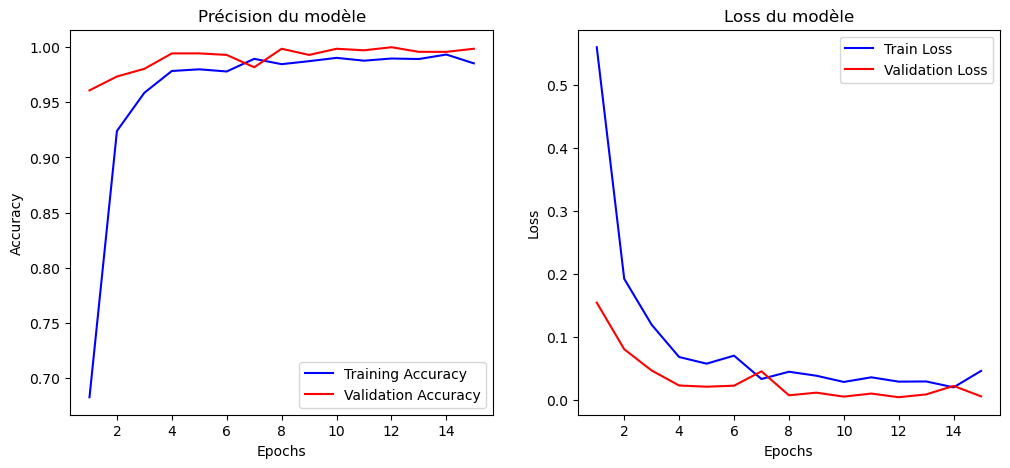

In [11]:
# Récupération des valeurs d'accuracy et loss depuis l'objet 'historique'
# 'historique' contient toutes les métriques enregistrées lors de l'entraînement
acc = historique.history['accuracy']           # Accuracy sur le dataset d'entraînement
val_acc = historique.history['val_accuracy']   # Accuracy sur le dataset de validation
loss = historique.history['loss']              # Loss sur le dataset d'entraînement
val_loss = historique.history['val_loss']      # Loss sur le dataset de validation

# Création d'une séquence d'époques pour l'axe x des graphiques
epochs = range(1, len(acc) + 1)

# Configuration de la figure (largeur=12, hauteur=5)
plt.figure(figsize=(12, 5))

# Premier sous-graphique : Accuracy
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, graphique 1
plt.plot(epochs, acc, 'b', label='Training Accuracy')     # Courbe d'accuracy entraînement (bleu)
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy') # Courbe d'accuracy validation (rouge)
plt.title('Précision du modèle')  # Titre du graphique
plt.xlabel('Epochs')              # Axe des x : nombre d'époques
plt.ylabel('Accuracy')            # Axe des y : précision
plt.legend()                      # Affichage de la légende

# Deuxième sous-graphique : Loss
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, graphique 2
plt.plot(epochs, loss, 'b', label='Train Loss')          # Courbe de loss entraînement (bleu)
plt.plot(epochs, val_loss, 'r', label='Validation Loss') # Courbe de loss validation (rouge)
plt.title('Loss du modèle')  # Titre du graphique
plt.xlabel('Epochs')         # Axe des x : nombre d'époques
plt.ylabel('Loss')           # Axe des y : loss
plt.legend()                 # Affichage de la légende

# Affichage final de la figure
plt.show()

---

## Test du Modèle sur des Images Individuelles

### Test 1 : Prédiction sur une Pièce Conforme (OK)

Nous allons tester le modèle sur une image du dossier **`ok_front`** pour vérifier s'il la classifie correctement.

#### Processus de Prédiction :
1. **Chargement** de l'image depuis le disque
2. **Redimensionnement** à 250×250 pixels
3. **Conversion** en tableau NumPy
4. **Ajout d'une dimension batch** (le modèle attend un lot d'images)
5. **Normalisation** (division par 255)
6. **Prédiction** :  Le modèle retourne une probabilité entre 0 et 1

#### Interprétation :
- **Probabilité > 0.5** → Classe 1 (`ok_front`) = **OK**
- **Probabilité ≤ 0.5** → Classe 0 (`def_front`) = **DÉFAUT**

---

In [12]:
# Test du modèle sur une image du test OK

# Nom du fichier test
fichier_test = "cast_ok_0_1002.jpeg"

# Création du chemin complet vers l'image test
chemin_image_test = os.path.join(chemin_base, "test", "ok_front", fichier_test)

In [13]:
# Charger l'image et la redimensionner à la taille attendue par le modèle (250x250)
img = image.load_img(chemin_image_test, target_size=(250, 250))

# Convertir l'image en tableau NumPy (pixels)
img_array = image.img_to_array(img)

# Ajouter une dimension pour le batch (modèle attend une entrée de forme (1, 250, 250, 3))
img_array = np.expand_dims(img_array, axis=0)

# Normaliser les pixels entre 0 et 1 (comme pour l'entraînement)
img_array /= 255.0

In [14]:
print(f"Image test utilise : {chemin_image_test}")

Image test utilise : E:\ISMAGI\CI2 sem1\IA\Projet\datasets\quality\casting_data\test\ok_front\cast_ok_0_1002.jpeg


In [15]:
prediction = model.predict(img_array)[0][0]

# Interprétation de la probabilité
if prediction > 0.5:
    print("-> Le modèle prédit : OK")
else:
    print("-> Le modèle prédit : DEFAUT")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
-> Le modèle prédit : OK


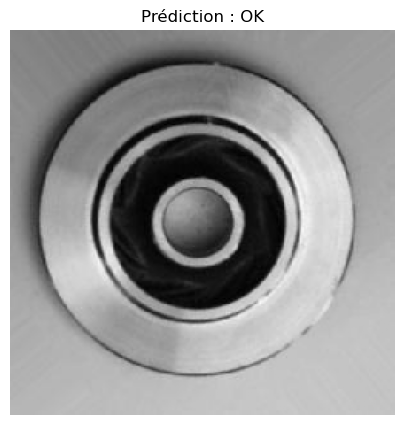

In [16]:
plt.figure(figsize=(5, 5))
plt.imshow(img_array[0])  # On affiche l'image (première dimension = batch)
plt.axis('off')           # On enlève les axes
plt.title(f"Prédiction : {'OK' if prediction > 0.5 else 'DEFAUT'}")
plt.show()

---

### Test 2 : Prédiction sur une Pièce Défectueuse

Maintenant, testons le modèle sur une image du dossier **`def_front`** (pièce avec défaut).

Le modèle devrait retourner une **probabilité ≤ 0.5**, indiquant la présence d'un défaut.

---

Image test utilise : E:\ISMAGI\CI2 sem1\IA\Projet\datasets\quality\casting_data\test\def_front\cast_def_0_242.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
-> Le modèle prédit : DEFAUT


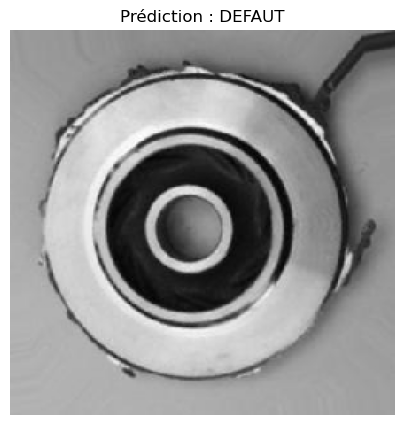

In [17]:
# Test du modèle sur une image du test défaut
# Nom du fichier test
fichier_test = "cast_def_0_242.jpeg"

# Création du chemin complet vers l'image test
chemin_image_test = os.path.join(chemin_base, "test", "def_front", fichier_test)

# Charger l'image et la redimensionner à la taille attendue par le modèle (250x250)
img = image.load_img(chemin_image_test, target_size=(250, 250))

# Convertir l'image en tableau NumPy (pixels)
img_array = image.img_to_array(img)

# Ajouter une dimension pour le batch (modèle attend une entrée de forme (1, 250, 250, 3))
img_array = np.expand_dims(img_array, axis=0)

# Normaliser les pixels entre 0 et 1 (comme pour l'entraînement)
img_array /= 255.0

print(f"Image test utilise : {chemin_image_test}")

prediction = model.predict(img_array)[0][0]

# Interprétation de la probabilité
if prediction > 0.5:
    print("-> Le modèle prédit : OK")
else:
    print("-> Le modèle prédit : DEFAUT")

plt.figure(figsize=(5, 5))
plt.imshow(img_array[0])  # On affiche l'image (première dimension = batch)
plt.axis('off')           # On enlève les axes
plt.title(f"Prédiction : {'OK' if prediction > 0.5 else 'DEFAUT'}")
plt.show()

## Conclusion et Résultats

### Récapitulatif du Projet

Dans ce projet, nous avons développé un **système de contrôle qualité automatisé** basé sur un **réseau de neurones convolutionnel (CNN)** afin de détecter les défauts sur des pièces de fonderie à partir d’images industrielles.

### Performances Obtenues

- **Architecture** : CNN composé de 4 blocs convolutionnels  
- **Dataset** : 6 634 images d’entraînement et 715 images de test  
- **Accuracy finale (validation)** : *99,86 %*  
- **Temps d’entraînement** : *86 minutes 54 secondes*  

Les résultats montrent que l’approche par CNN est efficace pour la détection automatique des défauts en environnement industriel.

### Applications Industrielles

Ce modèle peut être déployé dans une usine afin de :

1. **Assurer une inspection automatique 24/7** sans fatigue humaine  
2. **Réaliser une détection rapide**, avec un temps de prédiction inférieur à une seconde par pièce  
3. **Réduire les coûts de production** en limitant les rebuts et les contrôles manuels  
4. **Améliorer la traçabilité** grâce à l’enregistrement automatique des résultats  

### Améliorations Possibles
 
- **Augmentation du nombre d’epochs** : 20 à 30 epochs pour une meilleure convergence  
- **Optimisation des hyperparamètres** : batch size, learning rate, etc.  
- **Détection multi-classes** : classification selon le type de défaut  

---

### Ressources Utilisées

- **Dataset** : [Casting Product Image Data – Kaggle](https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product)  
- **Framework** : TensorFlow / Keras  
- **Documentation** : [Keras CNN Guide](https://keras.io/guides/)

---

### Auteurs

**MEZOUAHI Kaoutar**  
**AGOURARI Ossama**

Projet de Fin de Module : *Concepts de l’Intelligence Artificielle*  
Thème : *Transformation des Métiers – IA et Industrie 4.0*

---

**Date** : 14-01-2026
